In [4]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)


In [5]:
# inspections
insp = pd.read_csv("data/inspections.csv")

# violations
viol = pd.read_csv("data/violations.csv")

(ch:wrangling_transformations)=
# Transformations and Timestamps

At times a feature is not in a form best suited for analysis and so we
transform it. There are many reasons a feature might need a transformation. The
value codings might not be useful for analysis, we may want to combine two
features into one using an arithmetic expression, or we might want to pull
information out of a feature to create a new feature. We describe these three
basic kinds of transformations: type conversions, mathematical transformations,
and extractions.

**Type conversion.** This kind of transformation occurs when we convert the
data from one format to another to make the data more useful for analysis. We
might convert information stored as a string to another format. For example, we
would want to convert prices reported as strings to numeric (like changing the
string `"$2.17"` to the number 2.17) so that we can compute summary statistics
on them. Or, we might want to convert a time stored as a string, such as
"1955-10-12", to a datetime format. Yet another example occurs when we lump
categories together, such as reducing the 11 categories for age in DAWN to 5
groupings.     

**Mathematical transformation.** One kind of mathematical transformation is
when we change the units of a measurement from, say, pounds to kilograms. We
might make unit conversions so statistics on our data can be more easily
compared to other statistics.  Yet another reason to transform a feature is to
make its distribution more symmetric (covered in more detail in
{numref}`Section %s <ch:eda_distributions>`).
The most common transformation for this is the logarithm;
another widely used transformation is the square root. Lastly, we might want
to create new features from an arithmetic operations on others. For example,
we can combine heights and weights to create body mass index by calculating
$\text{height} / \text{weight}^2$. 


**Extraction**: Sometimes we will want to create a feature that contains
partial information taken from another feature. For example, the inspection
violations consists of a string with a description of the violation, and we may
be interested in only whether the violation is related to, say vermin. We can
create a new feature that is `True` if the violation contains the word "vermin"
in its text description and `False` otherwise.  This conversion of information
to logical values (or 0-1 values) is extremely useful in data science. The
example in {numref}`Section %s <ch:wrangling_restaurants>` gives a concrete
use case for these binary features. 

We cover many other examples of useful transformations in the
{ref}`ch:eda` chapter. For the rest of this section, we'll explain one more
transformation in detail: transforming dates and times. Dates and
times appear in many kinds of data, so it's worth learning how to work with
these data types.

## Transforming Timestamps

A **timestamp** is a data value that records a specific point in time.
Timestamps hold both a date and a time, and `pandas` has special support for
this data type. Let's take a look at an example. The `insp` dataframe records
when restaurant inspections happened. We see that the `date` column looks like
a timestamp.

In [3]:
insp

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
...,...,...,...,...
14219,94142,100,20171220,routine
14220,94189,96,20171130,routine
14221,94231,85,20171214,routine


By default, however, `pandas` reads in the `date` column as an integer:

In [6]:
insp['date']

0        20160513
1        20171211
2        20171101
           ...   
14219    20171220
14220    20171130
14221    20171214
Name: date, Length: 14222, dtype: int64

This storage type makes it hard to answer some useful questions about the data.
Do inspections happen more often on the weekends? Or the weekdays? To answer
this question, we want to convert the `date` column to the `pandas` Timestamp
storage type.

The `date` values appear to come in the format: `YYYYMMDD`, where `YYYY`,
`MM`, and `DD` correspond to the year, month, and day.
The `pd.to_datetime()` method can parse the date strings into objects, and
we can pass in the format of the dates as a date format string [^strftime].

[^strftime]: For more about date format strings, see the quick reference at
https://strftime.org/ or
[the Python documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

In [8]:
# This is the Python representation of the YYYYMMDD format
date_format = '%Y%m%d'

# Converts the date column to datetime objects
insp_dates = pd.to_datetime(insp['date'], format=date_format)
insp_dates

0       2016-05-13
1       2017-12-11
2       2017-11-01
           ...    
14219   2017-12-20
14220   2017-11-30
14221   2017-12-14
Name: date, Length: 14222, dtype: datetime64[ns]

We can see that the `insp_dates` now has a `dtype` of `datetime64[ns]`, which
means that the values were successfully converted into `pd.Timestamp` objects
[^datetimes].

[^datetimes]: `datetime64[ns]` means that `pandas` uses 64 bits of memory for
    each value, and that each datetime is accurate to the nanosecond (or ns,
    for short).

:::{note}

The `pd.to_datetime()` method tries to automatically infer the timestamp format
if we don't pass in the `format=` argument. In many cases `pandas` will parse
the timestamps properly. However, sometimes the parsing doesn't output the
correct timestamps (including this case), so we must explicitly specify the
format. 

:::



`pandas` has special methods and properties for Series objects
that hold timestamps using the `.dt` accessor. For instance, we can easily pull
out the year for each timestamp:


In [9]:
insp_dates.dt.year

0        2016
1        2017
2        2017
         ... 
14219    2017
14220    2017
14221    2017
Name: date, Length: 14222, dtype: int64

The `pandas` documentation has the complete details on the `.dt` accessor [^dt]. By
looking at the documentation, 
we see that the `.dt.day_of_week` attribute gets the day of week for each
timestamp (Monday=0, Tuesday=1, ..., Sunday=6).

[^dt]: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components

In [10]:
insp_dates.dt.day_of_week

0        4
1        0
2        2
        ..
14219    2
14220    3
14221    3
Name: date, Length: 14222, dtype: int64

So, let's assign new columns to the `insp` dataframe containing both the parsed
timestamps and the day of week for each timestamp.

In [13]:
insp = insp.assign(timestamp=insp_dates, dow=insp_dates.dt.day_of_week)
insp

,business_id,score,date,type,timestamp,dow
0,19,94,20160513,routine,2016-05-13,4
1,19,94,20171211,routine,2017-12-11,0
2,24,98,20171101,routine,2017-11-01,2
...,...,...,...,...,...,...
14219,94142,100,20171220,routine,2017-12-20,2
14220,94189,96,20171130,routine,2017-11-30,3
14221,94231,85,20171214,routine,2017-12-14,3


Now, we can see whether restaurant inspectors favor a certain day of the week
by grouping on the `dow` column.

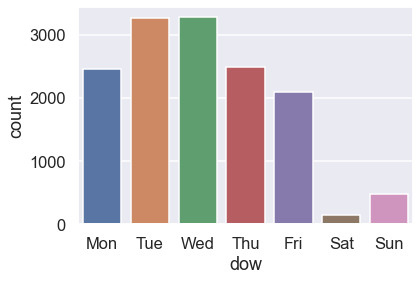

In [23]:
sns.countplot(x='dow', data=insp)

# set xticklabels to be the day of the week
plt.gca().set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

So, restaurant owners can generally expect inspections to happen on a weekday
rather than a weekend.

## Using pipe() For Transformations

In real data analyses, we typically apply many transformations on the data.
However, it is easy to introduce bugs when we repeatedly mutate a dataframe
because Jupyter notebooks let us run cells in any order we want. As good
practice, we recommend putting transformation code into functions with clear
names and using the `DataFrame.pipe()` method to chain transformations
together.

For example, let's rewrite the timestamp parsing code above into a function.
We'll also add the timestamps back into the dataframe as a new column, and add
a second column containing the year for each timestamp.

In [27]:
date_format = '%Y%m%d'

# A transformation function takes in a dataframe as its first input and returns
# the transformed dataframe. We can add optional parameters via keyword
# arguments.
def parse_dates_and_years(df, column='date'):
    dates = pd.to_datetime(df[column], format=date_format)
    years = dates.dt.year
    return df.assign(timestamp=dates, year=years)

Now, we can pipe the `insp` dataframe through this function using `.pipe()`:

In [29]:
insp = (pd.read_csv("data/inspections.csv")
        .pipe(parse_dates_and_years))
insp

,business_id,score,date,type,timestamp,year
0,19,94,20160513,routine,2016-05-13,2016
1,19,94,20171211,routine,2017-12-11,2017
2,24,98,20171101,routine,2017-11-01,2017
...,...,...,...,...,...,...
14219,94142,100,20171220,routine,2017-12-20,2017
14220,94189,96,20171130,routine,2017-11-30,2017
14221,94231,85,20171214,routine,2017-12-14,2017


We can chain as many `.pipe()` calls as we want.

In [30]:
def extract_day_of_week(df, col='timestamp'):
    return df.assign(dow=df[col].dt.day_of_week)

insp = (pd.read_csv("data/inspections.csv")
        .pipe(parse_dates_and_years)
        .pipe(extract_day_of_week))
insp

,business_id,score,date,type,timestamp,year,dow
0,19,94,20160513,routine,2016-05-13,2016,4
1,19,94,20171211,routine,2017-12-11,2017,0
2,24,98,20171101,routine,2017-11-01,2017,2
...,...,...,...,...,...,...,...
14219,94142,100,20171220,routine,2017-12-20,2017,2
14220,94189,96,20171130,routine,2017-11-30,2017,3
14221,94231,85,20171214,routine,2017-12-14,2017,3


There are several key advantages of using `pipe()`. First, when there are many
transformations on a single dataframe, it's easier to see what transformations
happen since we can simply read the function names. Second, we can reuse
transformation functions for different dataframes. For instance, the `viol`
dataframe, which contains restaurant safety violations, also has a `date`
column.

In [31]:
viol

,business_id,date,description
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
...,...,...,...
39039,94231,20171214,High risk vermin infestation [ date violation...
39040,94231,20171214,Moderate risk food holding temperature [ dat...
39041,94231,20171214,Wiping cloths not clean or properly stored or ...


This means we can use `.pipe()` to reuse the timestamp parsing function without
needing to write extra code. Convenient!

In [32]:
# Instead of rewriting the timestamp parsing code, we can simply reuse the
# parse_dates_and_years function we defined earlier.
viol = (pd.read_csv("data/violations.csv")
        .pipe(parse_dates_and_years)) 
viol

,business_id,date,description,timestamp,year
0,19,20171211,Inadequate food safety knowledge or lack of ce...,2017-12-11,2017
1,19,20171211,Unapproved or unmaintained equipment or utensils,2017-12-11,2017
2,19,20160513,Unapproved or unmaintained equipment or utensi...,2016-05-13,2016
...,...,...,...,...,...
39039,94231,20171214,High risk vermin infestation [ date violation...,2017-12-14,2017
39040,94231,20171214,Moderate risk food holding temperature [ dat...,2017-12-14,2017
39041,94231,20171214,Wiping cloths not clean or properly stored or ...,2017-12-14,2017


## Takeaways

In this section, we gave an overview of the most common transformations that we
perform when cleaning data. Next, we also introduced working with timestamps in
`pandas`. Finally, we showed how using the `.pipe()` function is a useful
practice for applying multiple transformations. In the next section, we'll
explain another common type of transformation: modifying the structure of a
dataframe.